In [12]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import chi2, entropy
from collections import Counter

from utils import flatten,rolling_window,get_click_data

from vlmc import preprocess_clicks, VLMC

# 1. Get Click Data

In [2]:
clicks = get_click_data()

/tmp/ipykernel_3002979/2062889381.py:1: DtypeWarning: Columns (46,49) have mixed types.Specify dtype option on import or set low_memory=False.
  clicks = get_click_data()


# 2. Preprocess to VLMC

In [3]:
raw_sequences, sequences, counts, n_bins = preprocess_clicks(clicks)

# 3. Build VLMC 

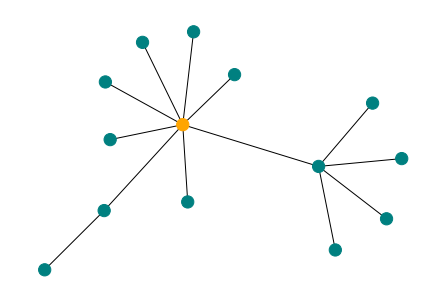

In [7]:
tree=VLMC(n_bins).fit(sequences,counts)
G = nx.Graph(tree.A) 
nx.draw(G, node_color=['orange']+['teal']*(len(G.nodes)-1),node_size=150,edge_color='black')

# 4. Cutoff value

### 4.1 Log Likelyhood Function

In [9]:
def LogLike(tree, list_sequences,null_model=False):
    PX,PX0=[],[]
    contexts = [tree.sequences[i] for i in tree.matrix]
    
    for seq in list_sequences:
        if type(seq)!=list:
            seq=seq.tolist()

        j,px,p_x = 0,1,1
        for i in range(len(seq)):
            context = seq[j:i]
            if context not in contexts:
                j=i
                context = seq[j:i]

            ind = tree.sequences.index(context)
            p_x *= tree.get_dist(0)[seq[i]]
            px *= tree.get_dist(ind)[seq[i]]

        PX.append(px),PX0.append(p_x)
    if null_model:
        return np.log(PX),np.log(PX0)  
    return np.log(PX)

### 4.2 Akike Information Index and  0-th Order Markov Model (naive implementation)

$$ AIC = 2k - 2ln(\hat{L}) $$


In [10]:
raw_sequences, sequences, counts, n_bins = preprocess_clicks(clicks)
PARAMS, LOGL, LOGLZero = [],[], []
for k in np.arange(15,210,15):
    #fit model
    tree = VLMC(n_bins).fit(sequences,counts,K=k)
    
    #log_likelyhood
    likelyhood, likelyhood0 = LogLike(tree,raw_sequences,null_model=True)
    LOGL.append(-np.sum(likelyhood))
    LOGLZero.append(-np.sum(likelyhood0))
    
    #n_params
    n_params = len(tree.matrix)*(tree.n_params-1) 
    PARAMS.append(n_params)

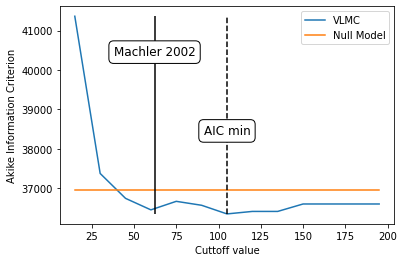

In [13]:
yy = np.array(PARAMS)+2*np.array(LOGL)
k = 0.5*chi2.ppf(0.95,n_bins-1)

plt.plot(np.arange(15,210,15),yy,label='VLMC')
plt.plot(np.arange(15,210,15), (tree.n_params-1)+2*np.array(LOGLZero),label='Null Model')
plt.vlines(np.arange(15,210,15)[np.argmin(yy)],np.min(yy),np.max(yy),linestyle='--',color='k')
plt.vlines(k,np.min(yy),np.max(yy),color='k')
plt.ylabel('Akike Information Criterion')
plt.text(k,np.max(yy)-1000,'Machler 2002',color='black',ha='center',
       bbox=dict(facecolor='white',edgecolor='black',boxstyle='round,pad=0.4'),fontsize=12)
plt.text(np.arange(15,210,15)[np.argmin(yy)],np.max(yy)-3000,'AIC min',color='black',ha='center',
       bbox=dict(facecolor='white',edgecolor='black',boxstyle='round,pad=0.4'),fontsize=12)
plt.xlabel('Cuttoff value')
plt.legend()
plt.show()


# 5. Temporal Resolution 

In [14]:
def metric_resolution(clicks, whale, resolutions=np.linspace(0.005,0.1,50)):

    PARAMS,PARAMS0, LOGL, LOGLZero= [],[], [],[]
    for resolution in resolutions:
        #fit model
        raw_sequences, sequences, counts, n_bins = preprocess_clicks(clicks,whale = whale, resolution = resolution)
        tree = VLMC(n_bins).fit(sequences,counts)

        #log_likelyhood
        likelyhood, likelyhood0 = LogLike(tree,raw_sequences,null_model=True)
        LOGL.append(-np.sum(likelyhood))
        LOGLZero.append(-np.sum(likelyhood0))

        #n_params
        n_params = len(tree.matrix)*(tree.n_params-1)
        PARAMS.append(n_params)
        PARAMS0.append(tree.n_params-1)
    return PARAMS,PARAMS0, LOGL, LOGLZero

In [15]:
whales = ['ATWOOD','FORK','PINCHY']
resolutions = np.linspace(0.005,0.1,30)

metrics = []
for whale in whales:
    PARAMS,PARAMS0, LOGL, LOGLZero = metric_resolution(clicks,whale=whale,resolutions =resolutions )
    metrics.append([PARAMS,PARAMS0, LOGL, LOGLZero])

/home/antonio/foldah/foldahenv/CETI/02_Code&Data/vlmc.py:84: RuntimeWarning: invalid value encountered in true_divide
  return dist/np.sum(dist)


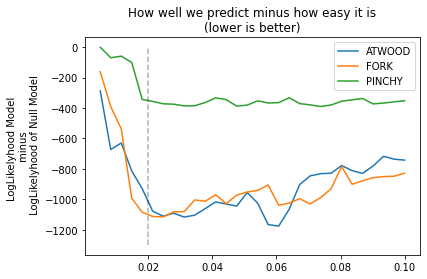

In [16]:
plt.figure()
for whale_metric,whale in zip(metrics,whales):
    plt.plot(resolutions,np.array(whale_metric[2])-np.array(whale_metric[3]), label = whale)
    
    #yy = 2*np.array(whale_metric[0])+2*np.array(whale_metric[2])
    #yy0 = 2*np.array(whale_metric[1])+2*np.array(whale_metric[3])
    #plt.plot(np.linspace(0.005,0.1,20),yy-yy0, label = whale)
plt.ylabel('LogLikelyhood Model \n minus \n LogLikelyhood of Null Model')
plt.vlines(0.02,-1300,0,linestyle='--',color='k',alpha=0.3)
plt.title('How well we predict minus how easy it is\n(lower is better)')
plt.legend()

# 6. Comparisons between whales and shuffled

In [411]:
1+1

2